# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\Austin\\anaconda3\\envs\\deep_learning\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

# Preprocessing

In [3]:
# Get the stock quote
df = pd.read_csv('C:/Users/Austin/Documents/Mustafa_Aydemir/Stock.csv') # Change this directory to yours.
# Set date_time as index
df = df.set_index('date_time')
# Show the data
df

,Open,High,Low,Close,Volume
date_time,,,,,
2/22/2016 10:00,0.001738,0.001685,0.001719,0.001712,0.000780
2/22/2016 11:00,0.001738,0.001685,0.001719,0.001738,0.000497
2/22/2016 12:00,0.001738,0.001685,0.001719,0.001738,0.000290
2/22/2016 14:00,0.001738,0.001711,0.001719,0.001738,0.005131
2/22/2016 15:00,0.001763,0.001711,0.001745,0.001738,0.001335
...,...,...,...,...,...
11/29/2019 12:00,0.001738,0.001685,0.001719,0.001738,0.002884
11/29/2019 14:00,0.001738,0.001685,0.001719,0.001712,0.001814
11/29/2019 15:00,0.001738,0.001685,0.001719,0.001738,0.002310


In [4]:
# Get the number of rows and columns in the data set
df.shape

(6503, 5)

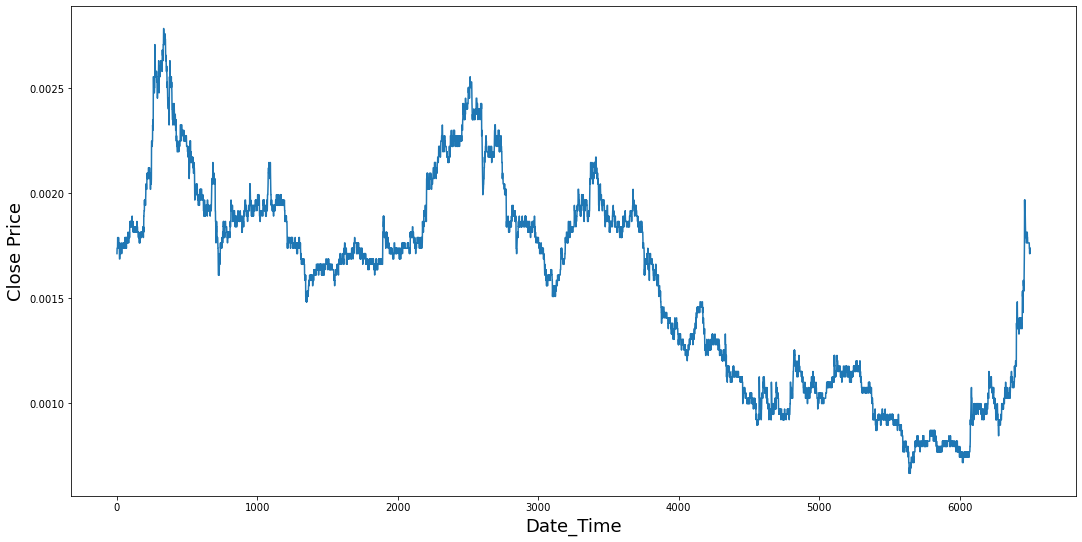

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Close']))
#plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date_Time',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [6]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = round(len(dataset) * .8)
training_data_len

5202

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.49397603],
       [0.50602397],
       [0.50602397],
       ...,
       [0.50602397],
       [0.49397603],
       [0.50602397]])

In [8]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [9]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(5142, 60)

In [10]:
# Reshape the data since LSTM expects 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(5142, 60, 1)

In [11]:
# Build the LSTM model
import keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

5142/5142 [==============================] - 189s 36ms/step - loss: 0.0014 - accuracy: 3.8323e-04


In [14]:
# Create the testing data set
# Create a new array containing scaled values from index 5142 to 6503
test_data = scaled_data[training_data_len-60:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [15]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # unscaling the values

In [18]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5.865268141790341e-06

C:\Users\Austin\anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


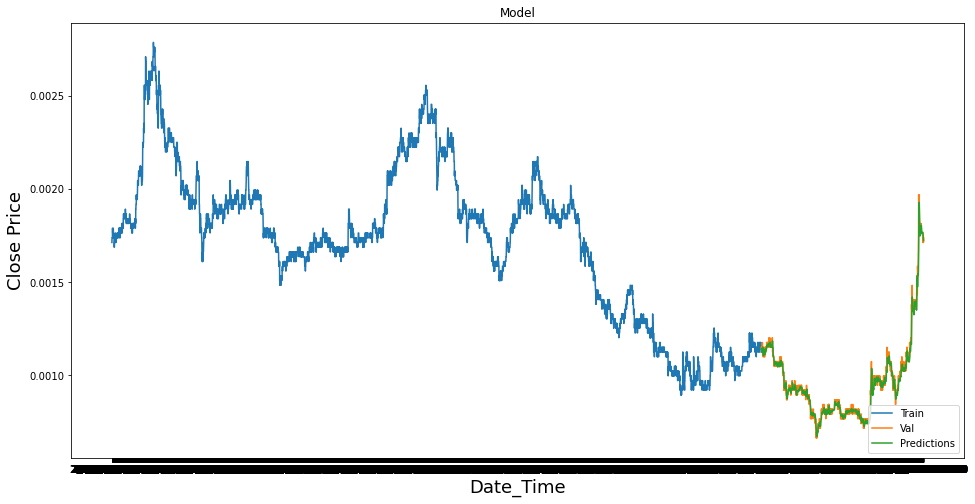

In [19]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date_Time', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
# Show the valid and predicted prices
valid

,Close,Predictions
date_time,,
2/15/2019 11:00,0.001150,0.001139
2/15/2019 12:00,0.001150,0.001137
2/15/2019 14:00,0.001150,0.001139
2/15/2019 15:00,0.001150,0.001141
2/15/2019 16:00,0.001124,0.001143
...,...,...
11/29/2019 12:00,0.001738,0.001756
11/29/2019 14:00,0.001712,0.001747
11/29/2019 15:00,0.001738,0.001731
